# APIs

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import root_mean_squared_error

# %pip install pypalettes
import pypalettes
from pypalettes import load_cmap

import warnings
warnings.filterwarnings('ignore', category=PendingDeprecationWarning)

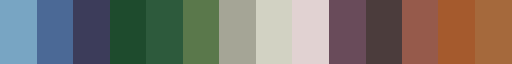

In [50]:
cmap = load_cmap('fleurs_dans_un_vase_de_cristal')
cmap

In [199]:
print(cmap.colors[4])

#2D5A3CFF


# Load data

In [9]:
train_csv = pd.read_csv('data/train.csv')

In [10]:
train_csv.shape

(7478, 33)

# Splitting Training data into Train and Test sets

In [138]:
y = train_csv['price']
cols_to_drop = ['price', 'scraped_time', 'id', 'technology_options', 'exterior_options', 'interior_options', 'description_score']
X = train_csv.drop(columns=cols_to_drop)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)

In [139]:
print(X_train.shape, y_train.shape,'\n', X_test.shape, y_test.shape)

(5608, 26) (5608,) 
 (1870, 26) (1870,)


# Baseline Model

In [152]:
categorical_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [155]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_encoder, selector(dtype_include='object'))
    ],
    remainder='passthrough'
)

Linear Regression

In [160]:
lr_pipe = make_pipeline(preprocessor, LinearRegression())

Random Forest

In [156]:
rf_pipe = make_pipeline(preprocessor, RandomForestRegressor())
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026F8E88B260>)])),
                ('randomforestregressor', RandomForestRegressor())])

In [157]:
y_pred = rf_pipe.predict(X_test)

In [159]:
score = root_mean_squared_error(y_test, y_pred)
print(f'RMSE score for the RF model is {score:.2f}')

RMSE score for the RF model is 8611.97


In [162]:
rf_cv = cross_val_score(rf_pipe, X_train, y_train, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
rf_cv

array([-15281.86406452,  -8077.1065653 , -30844.68928739, -22779.52318645,
       -30723.5872781 ])

# Submission Prediction

In [163]:
rf_pipe.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000026F8E88B260>)])),
                ('randomforestregressor', RandomForestRegressor())])

In [165]:
test_df = pd.read_csv('data/test.csv')
test_df.shape

(4027, 32)

In [167]:
test_df.rename(columns=cols_map, inplace=True)

In [170]:
cols_to_drop = ['scraped_time', 'id', 'technology_options', 'exterior_options', 'interior_options', 'description_score']
test_df_X = test_df.drop(columns=cols_to_drop)